<a href="https://colab.research.google.com/github/martimov/MoniTARE/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import cv2 as cv
from google.colab.patches import cv2_imshow
from sklearn.cluster import MeanShift, estimate_bandwidth
import os
import matplotlib.pyplot as plt
import numpy as np
import math

# Allows to render matplotlib figures directly in the notebook
%matplotlib inline 

import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
!git clone https://github.com/martimov/MoniTARE.git 

Cloning into 'MoniTARE'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 74 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [4]:
%cd MoniTARE

/content/MoniTARE


In [5]:
!ls

Perspective_correction.ipynb
README.md
Segmentation
Segmentation.ipynb
stereoLeft
stereoRight
video_BYEDP210102_2022-03-22_095346_wideshot.mp4_snapshot_00.10.663.jpg


(1080, 1920, 3)


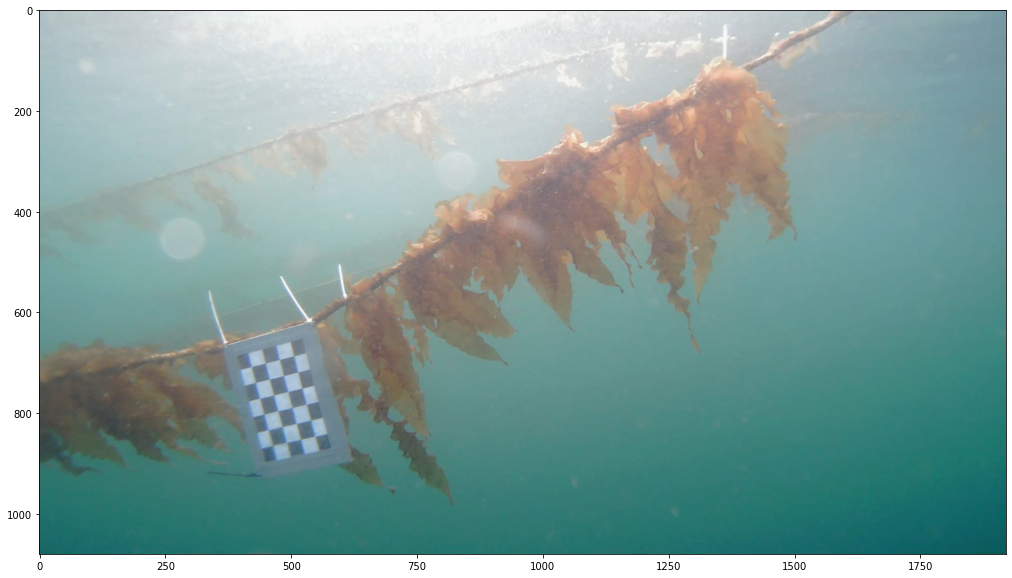

In [6]:
# Load an image and display
imgPath = 'video_BYEDP210102_2022-03-22_095346_wideshot.mp4_snapshot_00.10.663.jpg'
img = cv.imread(imgPath, cv.IMREAD_COLOR)

# Convert to grayscale
imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Display image
plt.imshow(img[:, :, ::-1]);
print(img.shape)

# Perspective correction

In [7]:
################ FIND CHESSBOARD CORNERS - OBJECT POINTS AND IMAGE POINTS #############################

chessboardSize = (4, 6)
frameSize = (1920, 1080)

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

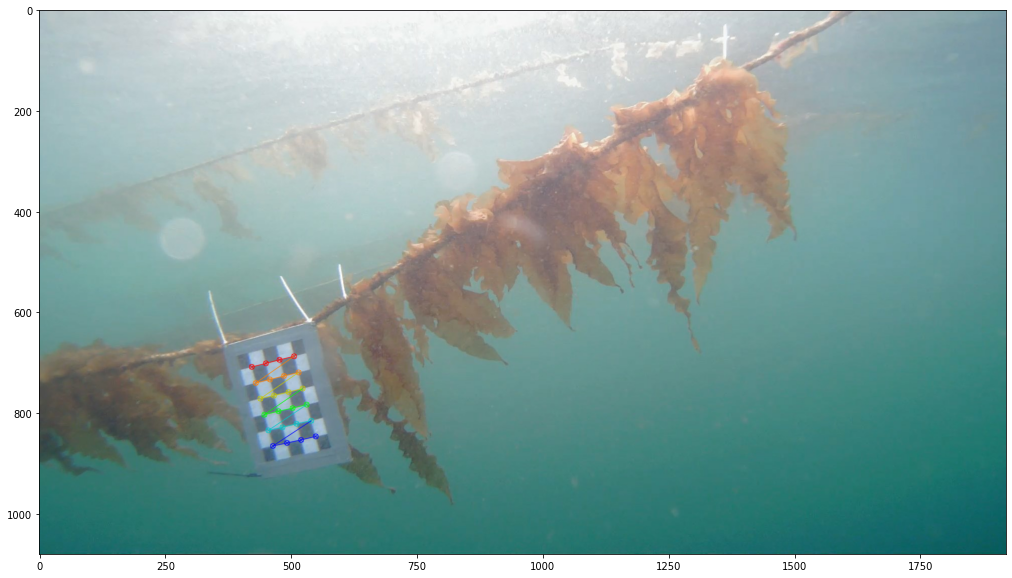

In [8]:
# Find the chess board corners
ret, corners = cv.findChessboardCorners(imgGray, chessboardSize, None)

# Copy image
imgCopy = img.copy()

# If found, add object points, image points (after refining them)
if ret == True:
  objpoints.append(objp)
  
  corners = cv.cornerSubPix(imgGray, corners, (11,11), (-1,-1), criteria)
  imgpoints.append(corners)
  # Draw and display the corners
  imgCopy = cv.drawChessboardCorners(imgCopy, chessboardSize, corners, ret)
  plt.imshow(imgCopy[:, :, ::-1]);

In [9]:
# Print the four corner points.
quad = np.float32([corners[0], corners[3], corners[23], corners[20]])
print(quad)

[[[422.08246 708.2529 ]]

 [[506.34476 686.9322 ]]

 [[548.57983 845.7995 ]]

 [[464.06226 864.87213]]]


In [10]:
# Define the four corners points (using the corners directly doesnt work for some reason).
input = np.float32([[422.08246, 708.2529], [506.34476, 686.9322], [548.57983, 845.7995], [464.06226, 864.87213]])

# Define the size of the output image.
hh, ww = img.shape[:2]

# Get top and left dimensions and set to output dimensions of chessboard.
# The math.hypot() method returns the Euclidean norm. The Euclidian norm is the distance from the origin to the coordinates given.
# width = math.hypot(x1 - x2, y1 - y2)
# height = math.hypot(x1 - x4, y1 - y4)
width = math.hypot(input[0,0]-input[1,0], input[0,1]-input[1,1])
height = math.hypot(input[0,0]-input[3,0], input[0,1]-input[3,1])
print("width:",width, "height:",height)

# Set upper left coordinates for output chessboard (same as upper left coordinates for the input chessboard).
x = input[0,0]
y = input[0,1]

# Specify output coordinates for corners of chessboard in order TL, TR, BR, BL as x.
output = np.float32([[x,y], [x+width-1,y], [x+width-1,y+height-1], [x,y+height-1]])
print(output)

width: 86.91782847021202 height: 162.14770339208278
[[422.08246 708.2529 ]
 [508.00027 708.2529 ]
 [508.00027 869.40063]
 [422.08246 869.40063]]


In [11]:
# compute perspective matrix
matrix = cv.getPerspectiveTransform(input,output)
print(matrix)

[[ 1.04895456e+00 -2.91599776e-01  1.93284163e+02]
 [ 3.54193529e-01  9.30560618e-01 -8.78664463e+01]
 [ 1.51136301e-04 -6.52464563e-05  1.00000000e+00]]


In [41]:
# do perspective transformation setting area outside input to black
# Note that output size is the same as the input image size
imgWarp = cv.warpPerspective(img, matrix, (ww,hh), cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=(0,0,0))

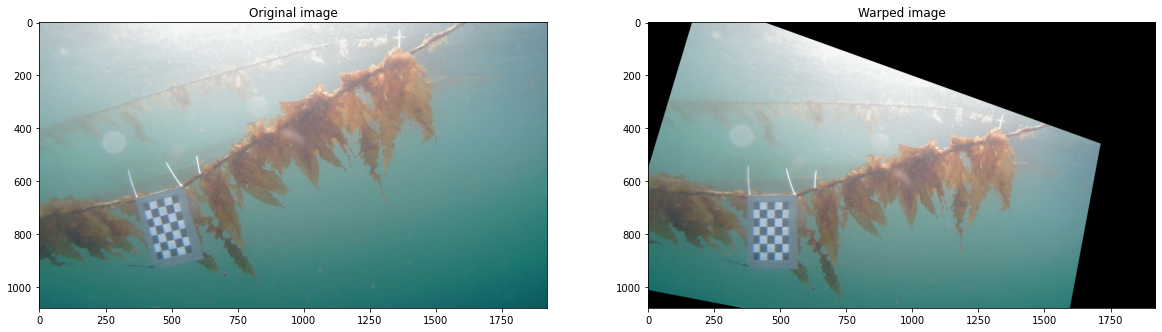

In [44]:
plt.figure()
plt.subplot(121); plt.imshow(img[:, :, ::-1]), plt.title('Original image')
plt.subplot(122); plt.imshow(imgWarp[:, :, ::-1]), plt.title('Warped image');

# MeanShift

In [ ]:
### PARAM TESTING LOOPS ###
# iterations = [1, 2, 4, 8, 16]
# for i in iterations:

# samples = [30, 300, 3000]
# for n in samples:

# quantiles = [.2, .15, .1, .05]
# for q in quantiles:

In [ ]:
# Filter to reduce noise
imgWarp = cv.medianBlur(imgWarp, 3)

# Flatten the image
imgFlat = imgWarp.reshape((-1,3))
imgFlat = np.float32(imgFlat)

# meanshift
bandwidth = estimate_bandwidth(imgFlat, quantile=.15, n_samples=300)

ms = MeanShift(bandwidth=bandwidth, max_iter=16, bin_seeding=True)

ms.fit(imgFlat)
labeled = ms.labels_

# get number of segments
segments = np.unique(labeled)

# get the average color of each segment
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
  total[label] = total[label] + imgFlat[i]
  count[label] += 1
avg = total/count
avg = np.uint8(avg)

# cast the labeled image into the corresponding avg color
res = avg[labeled]
imgMS = res.reshape((imgWarp.shape))

bandwidth: 32.77303901830395
Number of segments:  8


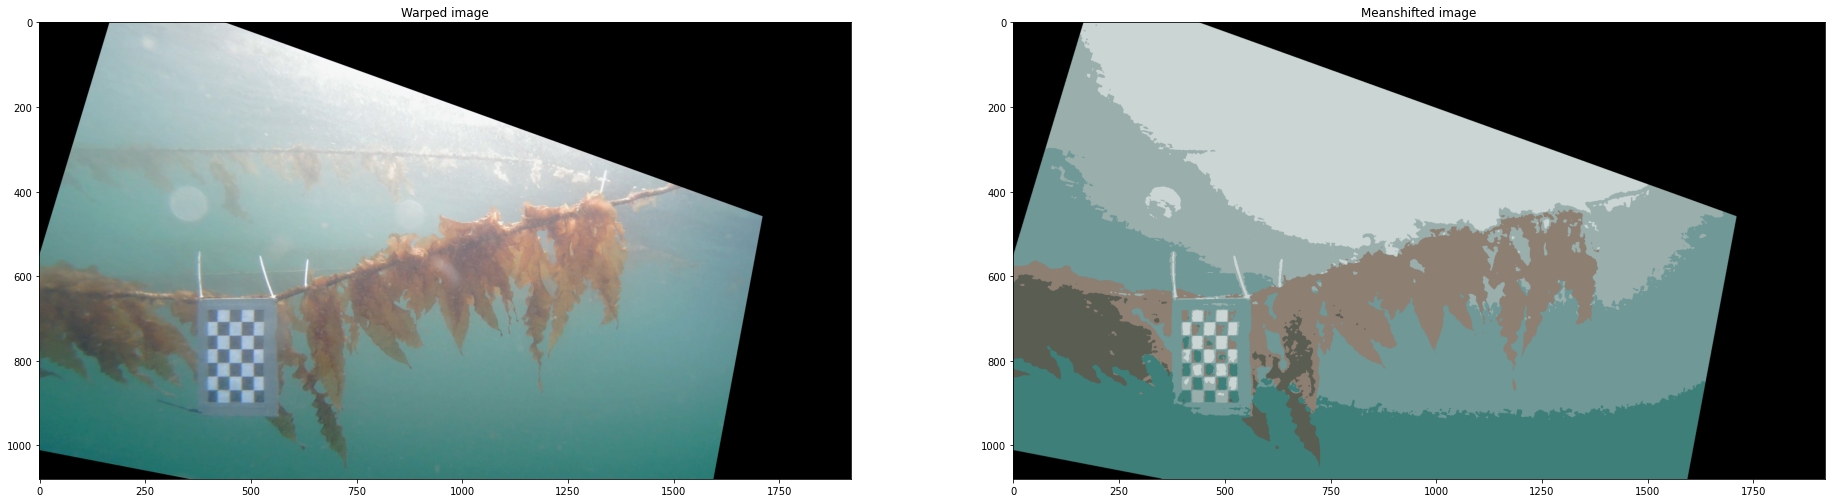

In [48]:
print("bandwidth:", bandwidth)
print('Number of segments: ', segments.shape[0])
plt.figure(figsize = [32, 20])
plt.subplot(121); plt.imshow(imgWarp[:, :, ::-1]), plt.title('Warped image')
plt.subplot(122); plt.imshow(imgMS[:, :, ::-1]), plt.title('Meanshifted image');

In [49]:
# meanshift
bandwidth = estimate_bandwidth(imgFlat, quantile=.2, n_samples=300)

ms = MeanShift(bandwidth=bandwidth, max_iter=16, bin_seeding=True)

ms.fit(imgFlat)
labeled = ms.labels_

# get number of segments
segments = np.unique(labeled)

# get the average color of each segment
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
  total[label] = total[label] + imgFlat[i]
  count[label] += 1
avg = total/count
avg = np.uint8(avg)

# cast the labeled image into the corresponding avg color
res = avg[labeled]
imgMS = res.reshape((imgWarp.shape))

bandwidth: 40.938971796727685
Number of segments:  5


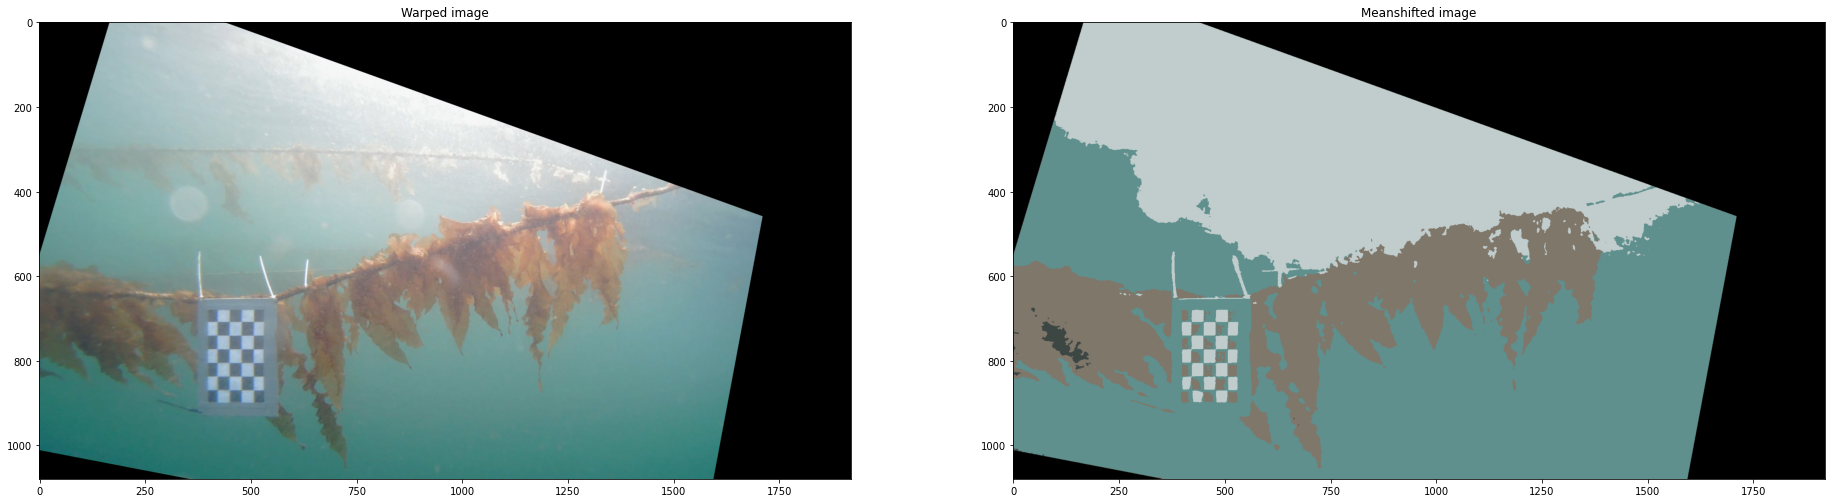

In [50]:
print("bandwidth:", bandwidth)
print('Number of segments: ', segments.shape[0])
plt.figure(figsize = [32, 20])
plt.subplot(121); plt.imshow(imgWarp[:, :, ::-1]), plt.title('Warped image')
plt.subplot(122); plt.imshow(imgMS[:, :, ::-1]), plt.title('Meanshifted image');

# Region of interest

In [ ]:
fillPoly()
Module 9 - Lane Detection using Hough Transforms 

# Stack images

In [ ]:
# Show intermediate results in a stacked image
imgStack = stackImages() 
# https://www.youtube.com/watch?v=WQeoO7MI0Bs&t=4585s